<a href="https://colab.research.google.com/github/DhruvaBansal00/ConfidentMT/blob/master/driver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
%cd drive/My Drive/ConfidentMachineTranslation/flores
!pwd
import sys
sys.path.append('/content/drive/My Drive/ConfidentMachineTranslation/flores/src/')

drive  sample_data
/content/drive/My Drive/ConfidentMachineTranslation/flores
analysis		  data-bin		     pointWiseComparison15.png
backward_models		  DeprecatedColabScripts     Resources
checkpoints		  driver.ipynb		     scripts
ClassificationDataset	  Ensembles		     sentencepiece_models
classifierComparison.png  language_models	     src
configs			  noisychannel
data			  pointWiseComparison10.png
/content/drive/My Drive/ConfidentMachineTranslation/flores


In [4]:
pip install fairseq sacrebleu sentencepiece fastBPE sacremoses xgboost

     |████████████████████████████████| 307kB 2.8MB/s 
     |████████████████████████████████| 61kB 6.2MB/s 
     |████████████████████████████████| 1.1MB 7.3MB/s 
     |████████████████████████████████| 890kB 17.8MB/s 
  Created wheel for fairseq: filename=fairseq-0.9.0-cp36-cp36m-linux_x86_64.whl size=2021173 sha256=babf6646a039cc412538e554bf23af1492669b140962211449cbf4e71fe51345
  Stored in directory: /root/.cache/pip/wheels/37/3e/1b/0fa30695dcba41e4b0088067fa40f3328d1e8ee78c22cd4766
  Created wheel for fastBPE: filename=fastBPE-0.1.0-cp36-cp36m-linux_x86_64.whl size=481520 sha256=62da678f43a6b111d7badf9e77142ff5f794588d8ae5dcf8750587bca1f50e7f
  Stored in directory: /root/.cache/pip/wheels/f3/0c/9c/fc62058b4d473a5602bcd3d3edfece796f123875379ea82d79
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=9519d3bc5823195c0ec13f97eceb2798e6b9f32697b6bf9f8299cdb07410a58d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a501

In [5]:
# prints how much GPU RAM is available
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=963331cc138e78f328a1aba23ce07a6003160b1dbbdaf754a4bf1968c2dfdf8a
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 161.1 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [6]:
##Methods for CLI with fairseq - WIP
import os
import glob
from tqdm.notebook import tqdm

class FairseqWrapper:

    def runFairseqGenerate(self, dataFolder, sourceLang, targetLang, fwModel, beam, lenpen, dataSet, removeBpe, saveFile):
        !fairseq-generate $dataFolder --source-lang $sourceLang --target-lang $targetLang \
        --path $fwModel --beam $beam --lenpen $lenpen --gen-subset $dataSet --remove-bpe=$removeBpe --sacrebleu > $saveFile

    def runFairseqScore(self, translations, groundTruth, saveFile, metric):
        !fairseq-score --sys $translations --ref $groundTruth --$metric > $saveFile
    
    def runFairseqPreprocessLM(self, srcdict, preprocCommand, bpeTranslations, dest):
        !fairseq-preprocess --only-source --srcdict $srcdict --$preprocCommand $bpeTranslations \
        --destdir $dest --workers 20
    
    def runFairseqPreprocessBinarize(self, srcLang, trgLang, srcdict, preprocCommand, bpeTranslations, destdir):
        !fairseq-preprocess --source-lang $srcLang --target-lang $trgLang --srcdict $srcdict\
        --$preprocCommand $bpeTranslations --destdir $destdir --joined-dictionary --workers 20

    def runFairseqEvalLM(self, preprocFile, lmModel, batchSize, maxTokens, dataSet, saveFile):
        !fairseq-eval-lm $preprocFile --path $lmModel --batch-size $batchSize --max-tokens $maxTokens \
        --output-word-probs --sample-break-mode eos --gen-subset $dataSet > $saveFile

    def deleteFolder(self, folder):
        print("Deleting contents in folder: " + str(folder))
        for f in tqdm(glob.glob(folder)):
            !rm $f
    

In [7]:
dataFolder = "data-bin/wiki_ne_en_bpe5000/"
fwModel = "Ensembles/April_04.pt"
bwModel = "backward_models/April_17.pt"
lmModel = "language_models/lm/checkpoint_best.pt"
sourceLang = "ne"
targetLang = "en"
ensembleFwModels = ":".join([i for i in glob.glob("Ensembles/*")])

In [8]:
import translationUtils
from translation import Translation
import dataUtils
import classification
import thresholding
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
trainTranslations = translationUtils.getTranslationFromDataset("valid", fwModel, bwModel, lmModel, "ne", "en", FairseqWrapper(), dataFolder, produceGraphs=False, saveTranslations=True)
testTranslations = translationUtils.getTranslationFromDataset("test", fwModel, bwModel, lmModel, "ne", "en", FairseqWrapper(), dataFolder, produceGraphs=False, saveTranslations=True)

In [ ]:
ensembleTranslations = translationUtils.getTranslationFromDataset("test", ensembleFwModels, bwModel, lmModel, "ne", "en", FairseqWrapper(), dataFolder, produceGraphs=False, saveTranslations=False)

In [10]:
import translationUtils
from translation import Translation
import dataUtils
import classification
import thresholding
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import random 

trainTranslations = dataUtils.createObjectsFromFile("valid")
testTranslations = dataUtils.createObjectsFromFile("test")

In [11]:
averageLogprobThresholding = thresholding.precisionCurveFromThresholding(testTranslations, np.linspace(-1.5, 0, 25).tolist(), 0, FairseqWrapper())
oracleThresholding = thresholding.precisionCurveFromThresholding(testTranslations, np.linspace(0, 60, 25).tolist(), 4, FairseqWrapper())
# ensembleThresholding = thresholding.precisionCurveFromThresholding(ensembleTranslations, np.linspace(-1.5, 0, 25).tolist(), 0, FairseqWrapper())

In [42]:
ncdClassifier = classification.precisionCurveFromClassification(trainTranslations, testTranslations, "LogisticRegression", FairseqWrapper(), np.linspace(0.1, 60, 25).tolist(), 
                                                                [0, 11, 12], [1, 2])

In [36]:
comparisonPoints = []
featureSubsets = [[0], #just baseline Forward Model score [P(T|S)]
                  [0, 11, 12], #Similar to noisy channel decoding: P(y|x), p(x|y), p(y) 
                  [0, 11, 12, 19, 20], #Like above + sentence length features
                  [0, 11, 12, 16, 17, 18], #Like above + ngram features
                  [0, 5, 6, 11, 12, 19, 20], #Like above + sentence length features + Rare words
                  [0, 11, 12, 13, 14, 19, 20], #Like above + sentence length features + end of sentence identifiers
                  [0, 5, 6, 11, 12, 16, 17, 18], #Like above + ngram features + Rare words
                  [0, 11, 12, 13, 14, 16, 17, 18], #Like above + ngram features + end of sentence identifiers
                  [0, 5, 6, 11, 12, 13, 14, 19, 20], #Like above + sentence length features + Rare words + end of sentence identifiers
                  [0, 5, 6, 11, 12, 13, 14, 16, 17, 18] #Like above + ngram features + Rare words + end of sentence identifiers
                  ]
for subset in featureSubsets:
    currPoints = classification.precisionCurveFromClassification(trainTranslations, testTranslations, "LogisticRegression", FairseqWrapper(), [15], subset, [i for i in range(1, len(subset))])
    comparisonPoints.append((currPoints[0][0], currPoints[1][0]))


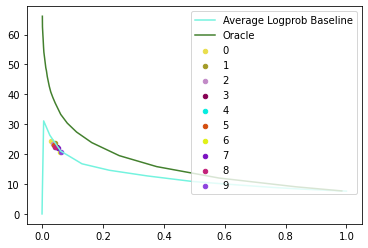

In [37]:
import matplotlib.pyplot as plt
import random 

plt.plot(averageLogprobThresholding[0], averageLogprobThresholding[1], label = "Average Logprob Baseline", color=(random.random(), random.random(), random.random()))
plt.plot(oracleThresholding[0], oracleThresholding[1], label = "Oracle", color=(random.random(), random.random(), random.random()))

for index, point in enumerate(comparisonPoints):
    plt.scatter([point[0]], [point[1]], label = str(index), color=(random.random(), random.random(), random.random()), s=20)

plt.legend(loc="upper right")
plt.savefig("pointWiseComparison10.png")
plt.show()


[averageLogprobThresholding] AUC for included fraction: 12.273183421516753
[oracleThresholding] AUC for included fraction: 16.294950617283952
[ncdClassifier] AUC for included fraction: 12.87656790123457


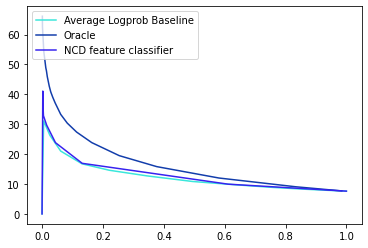

In [43]:
import matplotlib.pyplot as plt
import random 
from sklearn.metrics import auc

plt.plot(averageLogprobThresholding[0], averageLogprobThresholding[1], label = "Average Logprob Baseline", color=(random.random(), random.random(), random.random()))
plt.plot(oracleThresholding[0], oracleThresholding[1], label = "Oracle", color=(random.random(), random.random(), random.random()))
plt.plot(ncdClassifier[0], ncdClassifier[1], label = "NCD feature classifier", color=(random.random(), random.random(), random.random()))
# plt.plot(ensembleThresholding[0], ensembleThresholding[1], label = "Ensemble Average Baseline", color=(random.random(), random.random(), random.random()))

print("[averageLogprobThresholding] AUC for included fraction: {}".format(auc(averageLogprobThresholding[0], averageLogprobThresholding[1])))
print("[oracleThresholding] AUC for included fraction: {}".format(auc(oracleThresholding[0], oracleThresholding[1])))
print("[ncdClassifier] AUC for included fraction: {}".format(auc(ncdClassifier[0], ncdClassifier[1])))
# print("[ensembleAverageThresholding] AUC for included fraction: {}".format(auc(ensembleThresholding[0], ensembleThresholding[1])))


plt.legend(loc="upper left")
plt.savefig("classifierComparison.png")
plt.show()
